In [98]:
!pip install keras

You should consider upgrading via the '/Users/taliyas/PycharmProjects/NER/venv/bin/python -m pip install --upgrade pip' command.


In [99]:
!pip show tensorflow

Name: tensorflow
Version: 2.12.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /Users/taliyas/PycharmProjects/NER/venv/lib/python3.9/site-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, jax, keras, libclang, numpy, opt-einsum, packaging, protobuf, setuptools, six, tensorboard, tensorflow-estimator, tensorflow-io-gcs-filesystem, termcolor, typing-extensions, wrapt
Required-by: tensorflow-text


In [100]:
!pip install pandas openpyxl


You should consider upgrading via the '/Users/taliyas/PycharmProjects/NER/venv/bin/python -m pip install --upgrade pip' command.


### Take the labeled data that we have already prepared with the help of queries to ChatGPT

In [101]:
import pandas as pd

# Load the CSV file
data = pd.read_csv('GPTClassification.csv')
data.shape

(364, 2)

In [102]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 364 entries, 0 to 363
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Sentence  364 non-null    object
 1   category  362 non-null    object
dtypes: object(2)
memory usage: 5.8+ KB


In [103]:
data.head(10)

,Sentence,category
0,"""I think there should be many various sitting ...",Land use
1,"""It should be distinctive but still matching t...",Local identity
2,"""It should be clear where the entrance is and ...",Land use
3,"""well I think that the spaces should be focuse...","Land use, Future of work"
4,"""well it could be achieved through different m...",Land use
5,"""yes, the current building, as unsuitable as i...",Local identity
6,"""maybe, however Im interested in your suggesti...",other
7,"""i find that a very correct approach... how di...",other
8,"""correct again """,other
9,"""well maybe it is a possibility to experiment ...",Local identity


In [104]:
empty_string_count = (data['category'] == 'other').sum()
print("There is ", empty_string_count, " sentence that are not labeled")

There is  93  sentence that are not labeled


In [105]:
# delete the NuN values
data = data.dropna()

In [106]:
total_duplicate_titles = sum(data["Sentence"].duplicated())
print(f"There are {total_duplicate_titles} duplicate Sentences.")

There are 14 duplicate Sentences.


In [108]:
# Create a boolean mask for duplicated sentences
mask = data["Sentence"].duplicated(keep=False)

# Print the rows with duplicated sentences
data[mask]


,Sentence,category
17,"""no""",other
51,"""What spaces should be in the building?""","Future of work, Land use"
54,"""What should the building look like? """,Local identity
71,"""What spaces should be in the building?""",Land use
74,"""What should the building look like? """,Local identity
85,"""Hi Zaha""",other
97,"""What would you like to know""",other
123,"""spaces""","Environment and climate resilience, Land use"
127,"""trees grass""","Environment and climate resilience, Land use"
129,"""spaces""","Environment and climate resilience, Land use"


In [109]:
data = data[~data["Sentence"].duplicated()]
print(f"There are {len(data)} rows in the deduplicated dataset.")

# There are some categories with occurrence as low as 1.
print("categories upon once only:",sum(data["category"].value_counts() == 1))

# How many unique terms?
print("unique categories:",data["category"].nunique())

There are 348 rows in the deduplicated dataset.
categories upon once only: 14
unique categories: 31


We need to handle the categories upon only once, its problematic for multi-label text classifier

In [111]:
def get_single_occurrence_categories(data):
    # Get the categories that appear only once
    single_occurrence_categories = data['category'].value_counts()
    single_occurrence_categories = single_occurrence_categories[single_occurrence_categories == 1].index

    # Get the rows where 'category' is in the list of single-occurrence categories
    once_sen = data[data['category'].isin(single_occurrence_categories)]
    return once_sen


In [113]:
once_sen = get_single_occurrence_categories(data)
once_sen


,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","Local identity, Environment and climate resili..."
19,"""The building should be more open for the soci...","Local identity, Environment and climate resili..."
22,"""To have a cafe on the ground floor would be n...","Local identity, Mobility (transport)"
53,"""Can we have a garden?""","Land use, Environment and climate resilience"
110,"""I agree! Architecture students should be insp...","Environment and climate resilience, Future of ..."
145,"""The building should have several spaces for g...","Environment and climate resilience, Local iden..."
183,"""Can I 3d print infra lightweight concrete?""",Future of work; Land use
194,"""I think it should be more inviting compared t...",Local identity; Land use
198,"""There should be greenery aroud the building, ...",Environment and climate resilience; Land use
226,"""I think that a good architecture school shoul...",Land use; Local identity


In [114]:
# Replace ";" with ","
data['category'] = data['category'].str.replace(';', ',')


In [115]:
data["category"] = data["category"].apply(
    lambda x: x.split(', ')
)
data["category"].values[:5]


array([list(['Land use']), list(['Local identity']), list(['Land use']),
       list(['Land use', 'Future of work']), list(['Land use'])],
      dtype=object)

In [116]:
once_sen = get_single_occurrence_categories(data)
once_sen

,Sentence,category
15,"""hi, i think if there´s more free use co-worki...","[Local identity, Environment and climate resil..."
19,"""The building should be more open for the soci...","[Local identity, Environment and climate resil..."
22,"""To have a cafe on the ground floor would be n...","[Local identity, Mobility (transport)]"
53,"""Can we have a garden?""","[Land use, Environment and climate resilience]"
110,"""I agree! Architecture students should be insp...","[Environment and climate resilience, Future of..."
145,"""The building should have several spaces for g...","[Environment and climate resilience, Local ide..."
239,"""Hello Zaha, nice to meet you! I'm glad to be ...","[Environment and climate resilience, Local ide..."
316,"""I hope in office room or big classroom there ...",[Indoor comfort]
335,"""Who's your favorite architect what's your fav...","[Mobility (transport), Local identity]"


The categories that appear once in the data we took from 14 to 9.
Now for those 9 - we will separate them to different rows

In [117]:
# Create a list to store the new rows
new_rows = []

# Iterate over the rows in the dataframe where category is in single_occurrence_categories
for idx, row in once_sen.iterrows():
    # Iterate over the categories in the 'category' column
    for cat in row['category']:
        new_row = {'Sentence': row['Sentence'], 'category': [cat]}
        # Only add the new row if it is not already in new_rows
        if new_row not in new_rows:
            new_rows.append(new_row)
    data = data.drop(idx)

# Create a new DataFrame from the new rows
new_rows_df = pd.DataFrame(new_rows)

# Append the new rows to the dataframe using concat
data = pd.concat([data, new_rows_df], ignore_index=True)


In [118]:
# Convert lists in 'category' to tuples
new_rows_df['category'] = new_rows_df['category'].apply(tuple)

# Then check for duplicates
total_duplicate_titles = new_rows_df.duplicated().sum()
print(f"There are {total_duplicate_titles} duplicates.")



There are 0 duplicates.


In [119]:
# There are some categories with occurrence as low as 1.
print(once_sen['Sentence'][19])
data[data['Sentence'] == once_sen['Sentence'][19]]
# this cell for checking it was separated

"The building should be more open for the society."


,Sentence,category
342,"""The building should be more open for the soci...",[Local identity]
343,"""The building should be more open for the soci...",[Environment and climate resilience]


In [120]:
data.shape

(361, 2)

In [123]:
# Get the categories that appear more than once
multi_occurrence_categories = data['category'].value_counts()
multi_occurrence_categories = multi_occurrence_categories[multi_occurrence_categories > 1].index

# Filter the data to only include rows where 'category' is in the list of multi-occurrence categories
data = data[data['category'].isin(multi_occurrence_categories)]


In [124]:
data.shape

(360, 2)

In [125]:
test_split = 0.15
from sklearn.model_selection import train_test_split

# Initial train and test split.
train_df, test_df = train_test_split(
    data,
    test_size=test_split,
    stratify=data["category"].values,
)

# Splitting the test set further into validation
# and new test sets.
val_df = test_df.sample(frac=0.5)
test_df.drop(val_df.index, inplace=True)

print(f"Number of rows in training set: {len(train_df)}")
print(f"Number of rows in validation set: {len(val_df)}")
print(f"Number of rows in test set: {len(test_df)}")

Number of rows in training set: 306
Number of rows in validation set: 27
Number of rows in test set: 27


In [126]:
import tensorflow as tf
categories = tf.ragged.constant(train_df["category"].values)
print(categories)

<tf.RaggedTensor [[b'Mobility (transport)'], [b'Local identity'], [b'Local identity'],
 [b'Future of work'], [b'Local identity'],
 [b'Environment and climate resilience'], [b'other'], [b'Land use'],
 [b'Land use'], [b'Land use'], [b'Future of work'], [b'Land use'],
 [b'other'], [b'Land use'], [b'Future of work'], [b'Land use'],
 [b'Local identity'], [b'Local identity'], [b'other'], [b'other'],
 [b'Future of work', b'Land use'], [b'Land use'], [b'Land use'],
 [b'Land use'], [b'Future of work'], [b'Future of work'],
 [b'Mobility (transport)', b'Land use'], [b'other'], [b'Land use'],
 [b'Local identity'], [b'Land use'],
 [b'Environment and climate resilience'], [b'other'], [b'other'],
 [b'other'], [b'other'], [b'Environment and climate resilience'],
 [b'Environment and climate resilience', b'Local identity'],
 [b'Future of work'], [b'Future of work'],
 [b'Environment and climate resilience', b'Land use'], [b'Land use'],
 [b'other'], [b'Land use'], [b'Environment and climate resilience'],


## multi-hot encoding
We will convert the  categorical data into a form that can be used by deep learning models.
because we are dealing with multi-label classification problem.


In [129]:
# Convert tensors to numpy arrays and then to sets of tuples for set operations
train_categories_tensor = tf.ragged.constant(train_df["category"].values)
test_categories_tensor = tf.ragged.constant(test_df["category"].values)

train_categories = set(tuple(x) for x in train_categories_tensor.to_list())
test_categories = set(tuple(x) for x in test_categories_tensor.to_list())

categories_not_in_train = test_categories - train_categories

print(categories_not_in_train)


set()


the result is an empty set (set())- it means there are no categories that exist in the test set but not in the training set

In [130]:
import tensorflow as tf
#
categories = tf.ragged.constant(train_df["category"].values)
lookup = tf.keras.layers.StringLookup(output_mode="multi_hot", num_oov_indices=0)
lookup.adapt(categories)
vocab = lookup.get_vocabulary()


def invert_multi_hot(encoded_labels):
    """Reverse a single multi-hot encoded label to a tuple of vocab terms."""
    hot_indices = np.argwhere(encoded_labels == 1.0)[..., 0]
    return np.take(vocab, hot_indices)


print("Vocabulary:\n")
print(vocab)

2023-05-16 11:28:19.635902: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype variant and shape [306]
	 [[{{node Placeholder/_0}}]]


Vocabulary:

['Land use', 'other', 'Environment and climate resilience', 'Local identity', 'Future of work', 'Mobility (transport)']


In [131]:
sample_label = train_df["category"].iloc[0]
print(f"Original label: {sample_label}")

label_binarized = lookup([sample_label])
print(f"Label-binarized representation: {label_binarized}")


Original label: ['Mobility (transport)']
Label-binarized representation: [[0. 0. 0. 0. 0. 1.]]


In [132]:
train_df["Sentence"].apply(lambda x: len(x.split(" "))).describe()


count    306.000000
mean      12.663399
std       20.127164
min        1.000000
25%        5.000000
50%        8.000000
75%       13.000000
max      179.000000
Name: Sentence, dtype: float64

 the 75th percentile is at 13, meaning that 75% of the sentences have a length of 13 or less.
 and the maximum length observed is 179


In [115]:


# max_seqlen = 20
# batch_size = 128
# padding_token = "<pad>"
# auto = tf.data.AUTOTUNE
#
# # Tokenize categories
# tokenizer = Tokenizer()
# tokenizer.fit_on_texts(data["category"])
# num_classes = len(tokenizer.word_index) + 1  # Plus one for padding
#
# def make_dataset(dataframe, is_train=True):
#     # Tokenize and binarize labels
#     labels = tokenizer.texts_to_sequences(dataframe["category"])
#     print("labels: ",labels)
#     label_binarized = tf.keras.preprocessing.sequence.pad_sequences(labels, padding='post')
#     print("label_binarized: ",label_binarized)
#     # Create dataset
#     dataset = tf.data.Dataset.from_tensor_slices(
#         (dataframe["Sentence"].values, label_binarized)
#     )
#     dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
#     return dataset.batch(batch_size)


In [133]:
from tensorflow.keras.preprocessing.text import Tokenizer
max_seqlen = 20
batch_size = 128
padding_token = "<pad>"
auto = tf.data.AUTOTUNE


def make_dataset(dataframe, is_train=True):
    labels = tf.ragged.constant(dataframe["category"].values)
    label_binarized = lookup(labels).numpy()
    dataset = tf.data.Dataset.from_tensor_slices(
        (dataframe["Sentence"].values, label_binarized)
    )
    dataset = dataset.shuffle(batch_size * 10) if is_train else dataset
    return dataset.batch(batch_size)

In [134]:
train_dataset = make_dataset(train_df, is_train=True)
validation_dataset = make_dataset(val_df, is_train=False)
test_dataset = make_dataset(test_df, is_train=False)

In [135]:
test_df

,Sentence,category
312,"""That's great who were your teachers""",[other]
357,"""Hello Zaha, nice to meet you! I'm glad to be ...",[Mobility (transport)]
275,"""Personal and teamwork should be possible, but...",[Land use]
222,"""hide in the environment""",[Environment and climate resilience]
168,"""Can I 3d print infra lightweight concrete?""","[Future of work, Land use]"
229,"""space for eating, learning, working and gathe...",[Land use]
71,"""would there be any renovation""",[Land use]
300,"""comfortable spaces and facilities for both st...",[Future of work]
102,"""And I think it could be a good idea to use pa...",[Land use]
154,"""hi Zaha""",[other]


In [136]:
import numpy as np
text_batch, label_batch = next(iter(train_dataset))

for i, text in enumerate(text_batch[:5]):
    label = label_batch[i].numpy()[None, ...]
    print(label[0])
    print(f"Abstract: {text}")
    print(f"Label(s): {invert_multi_hot(label[0])}")
    print(" ")


[1. 0. 0. 0. 0. 0.]
Abstract: b'"The building should maximize the space provided to be efficient"'
Label(s): ['Land use']
 
[1. 0. 0. 0. 0. 0.]
Abstract: b'"we can also have a strairs in front of the building to use it for sitting or like a scene for some events and small concerts"'
Label(s): ['Land use']
 
[1. 0. 0. 0. 1. 0.]
Abstract: b'"Students need space to communicate"'
Label(s): ['Land use' 'Future of work']
 
[1. 0. 0. 0. 0. 0.]
Abstract: b'"It should be clear where the entrance is and if possible, there should be multiple entrances from various sides."'
Label(s): ['Land use']
 
[0. 0. 0. 0. 1. 0.]
Abstract: b'"a lot of student"'
Label(s): ['Future of work']
 


2023-05-16 11:34:01.940291: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype string and shape [306]
	 [[{{node Placeholder/_0}}]]
2023-05-16 11:34:01.943516: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [306,6]
	 [[{{node Placeholder/_1}}]]


In [137]:
vocabulary = set()
train_df["Sentence"].str.lower().str.split().apply(vocabulary.update)
vocabulary_size = len(vocabulary)
print(vocabulary_size)

1106


In [138]:
!pip install transformers


You should consider upgrading via the '/Users/taliyas/PycharmProjects/NER/venv/bin/python -m pip install --upgrade pip' command.


In [46]:
# from transformers import BertTokenizer, TFBertModel
#
# # Load pre-trained model tokenizer (vocabulary)
# bert_model_name = 'bert-base-uncased'
# tokenizer = BertTokenizer.from_pretrained(bert_model_name)
#
# # Load the pre-trained BERT model
# bert_model = TFBertModel.from_pretrained(bert_model_name)
#
# def encode_text(text):
#     """
#     This function takes a text input and returns the BERT-encoded tokens and the attention mask.
#     """
#     encoded = tokenizer.encode_plus(
#         text,
#         add_special_tokens=True,  # Add '[CLS]' and '[SEP]'
#         max_length=512,  # Maximum length for raw BERT input
#         return_attention_mask=True,  # Generate the attention mask
#         return_tensors='tf',  # Return TensorFlow tensors
#         truncation=True,  # Truncate to max_length
#         padding='max_length'  # Pad to max_length
#     )
#     return encoded["input_ids"], encoded["attention_mask"]
#
# # Use the encoding function to process your datasets
# train_dataset = train_dataset.map(lambda text, label: (encode_text(text), label), num_parallel_calls=auto).prefetch(auto)
# validation_dataset = validation_dataset.map(lambda text, label: (encode_text(text), label), num_parallel_calls=auto).prefetch(auto)
# test_dataset = test_dataset.map(lambda text, label: (encode_text(text), label), num_parallel_calls=auto).prefetch(auto)


SSLError: HTTPSConnectionPool(host='huggingface.co', port=443): Max retries exceeded with url: /bert-base-uncased/resolve/main/vocab.txt (Caused by SSLError(SSLCertVerificationError(1, '[SSL: CERTIFICATE_VERIFY_FAILED] certificate verify failed: self signed certificate in certificate chain (_ssl.c:1129)')))

In [139]:
from tensorflow.keras import layers
text_vectorizer = layers.TextVectorization(
    max_tokens=vocabulary_size, ngrams=2, output_mode="tf_idf"
)

# `TextVectorization` layer needs to be adapted as per the vocabulary from our
# training set.
with tf.device("/CPU:0"):
    text_vectorizer.adapt(train_dataset.map(lambda text, label: text))

train_dataset = train_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
validation_dataset = validation_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)
test_dataset = test_dataset.map(
    lambda text, label: (text_vectorizer(text), label), num_parallel_calls=auto
).prefetch(auto)

2023-05-16 11:36:13.013195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [306,6]
	 [[{{node Placeholder/_1}}]]
2023-05-16 11:36:13.015044: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [306,6]
	 [[{{node Placeholder/_1}}]]


### Create a text classification Model

In [146]:
def make_model():
    shallow_mlp_model = tf.keras.Sequential(
        [
            layers.Dense(512, activation="relu"),
            layers.Dense(256, activation="relu"),
            layers.Dense(128, activation="relu"),
            layers.Dense(64, activation="relu"),
            layers.Dense(lookup.vocabulary_size(), activation="sigmoid"),
        ]  # More on why "sigmoid" has been used here in a moment.
    )
    return shallow_mlp_model

## Train the model

Epoch 1/16
3/3 [==============================] - 3s 253ms/step - loss: 0.6951 - binary_accuracy: 0.6819 - precision: 0.1731 - recall: 0.2745 - f1_score: 0.2058 - val_loss: 0.5537 - val_binary_accuracy: 0.8210 - val_precision: 0.1779 - val_recall: 0.1765 - val_f1_score: 0.1772
Epoch 2/16
3/3 [==============================] - 0s 40ms/step - loss: 0.5320 - binary_accuracy: 0.8154 - precision: 0.2117 - recall: 0.1396 - f1_score: 0.1681 - val_loss: 0.5479 - val_binary_accuracy: 0.7778 - val_precision: 0.2414 - val_recall: 0.1497 - val_f1_score: 0.1848
Epoch 3/16
3/3 [==============================] - 0s 41ms/step - loss: 0.4837 - binary_accuracy: 0.8175 - precision: 0.2860 - recall: 0.1574 - f1_score: 0.2030 - val_loss: 0.5236 - val_binary_accuracy: 0.8148 - val_precision: 0.2970 - val_recall: 0.1506 - val_f1_score: 0.1999
Epoch 4/16
3/3 [==============================] - 0s 38ms/step - loss: 0.4655 - binary_accuracy: 0.8137 - precision: 0.3006 - recall: 0.1257 - f1_score: 0.1772 - val_lo

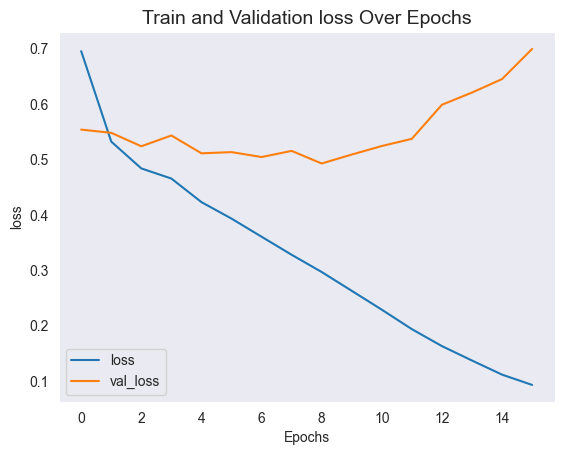

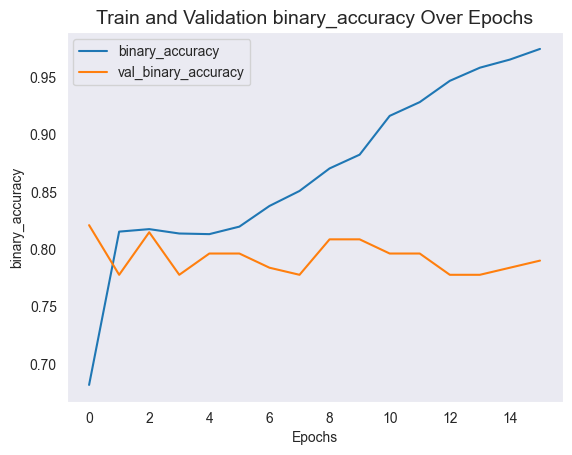

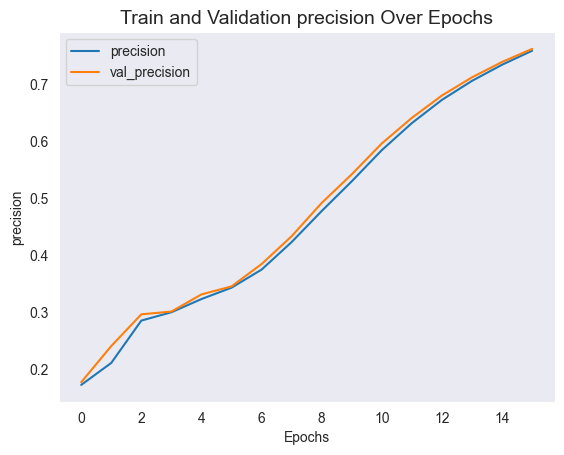

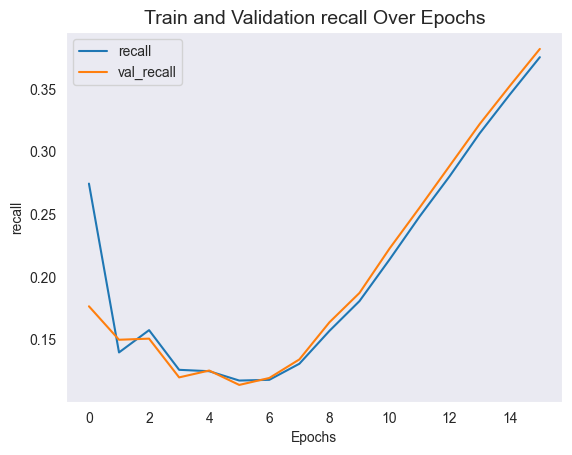

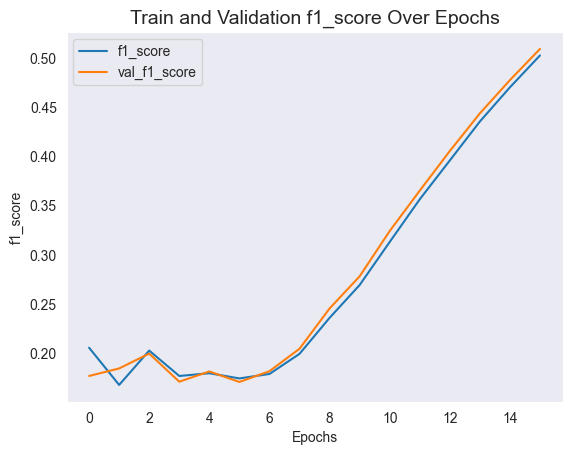

In [147]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.python.keras import metrics

import tensorflow as tf
#from tensorflow.keras import metrics

class F1Score(metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = metrics.Precision()
        self.recall = metrics.Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

    def result(self):
       precision = self.precision.result()
       recall = self.recall.result()
       return 2 * ((precision * recall) / (precision + recall + tf.keras.backend.epsilon()))


epochs = 16

shallow_mlp_model = make_model()
shallow_mlp_model.compile(
    loss="binary_crossentropy",
    optimizer="adam",
    metrics=[
        "binary_accuracy", #"binary_accuracy" checks for each position if the prediction is correct.
        metrics.Precision(name='precision'),
        metrics.Recall(name='recall'),
        F1Score()
    ]
)

history = shallow_mlp_model.fit(
    train_dataset, validation_data=validation_dataset, epochs=epochs
)

def plot_result(item):
    plt.plot(history.history[item], label=item)
    plt.plot(history.history["val_" + item], label="val_" + item)
    plt.xlabel("Epochs")
    plt.ylabel(item)
    plt.title("Train and Validation {} Over Epochs".format(item), fontsize=14)
    plt.legend()
    plt.grid()
    plt.show()

plot_result("loss")
plot_result("binary_accuracy")
plot_result("precision")
plot_result("recall")
plot_result("f1_score")


### Test part:
1. Predict labels for the test set using the model.
2. Convert these predicted probabilities to binary format (0 or 1) using a threshold of 0.5.
3. For each category:
* Extract the true and predicted labels for this category.
* Calculate and print the accuracy, precision, recall, and F1 score.
* Calculate and plot a confusion matrix for the category.

In [151]:

# Generate predictions on the test set
y_pred = shallow_mlp_model.predict(test_dataset)

# Convert predictions to binary format (0 or 1)
binary_predictions = np.round(y_pred)
binary_predictions

1/1 [==============================] - 0s 59ms/step


array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

In [152]:
y_true = np.vstack(test_dataset.map(lambda x, y: y).as_numpy_iterator())
y_true

2023-05-16 12:02:35.633179: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_10' with dtype float and shape [1106]
	 [[{{node Placeholder/_10}}]]
2023-05-16 12:02:35.633689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype float and shape [27,6]
	 [[{{node Placeholder/_1}}]]
/var/folders/jp/2wr1hx0s4zjdcnf63gtk75fw0000gq/T/ipykernel_85176/2842722914.py:1: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  y_true = np.vs

array([[0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 0.],
       [0., 0., 1., 1., 0., 0.],
       [0., 0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0.]], dtype=float32)

Category 1:

Accuracy: 0.8518518518518519
Precision: 0.8
Recall: 0.8
F1 Score: 0.8000000000000002



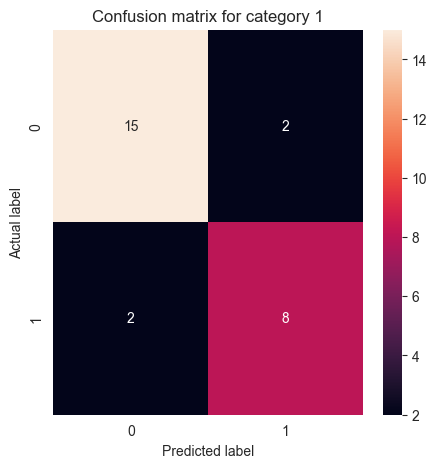

Category 2:

Accuracy: 0.8888888888888888
Precision: 1.0
Recall: 0.5714285714285714
F1 Score: 0.7272727272727273



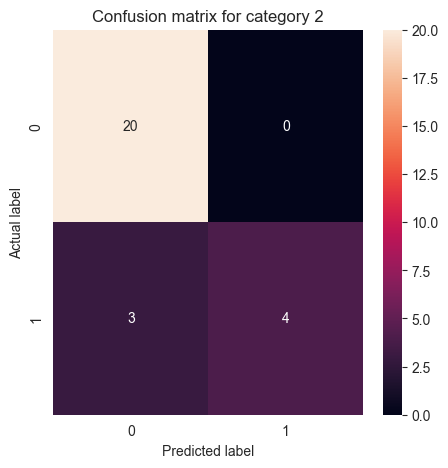

Category 3:

Accuracy: 0.8148148148148148
Precision: 0.5
Recall: 0.6
F1 Score: 0.5454545454545454



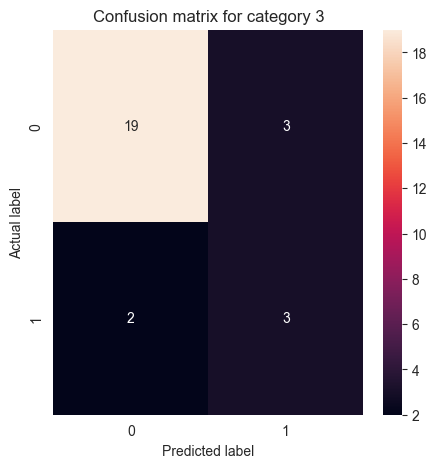

Category 4:

Accuracy: 0.8518518518518519
Precision: 0.6666666666666666
Recall: 0.4
F1 Score: 0.5



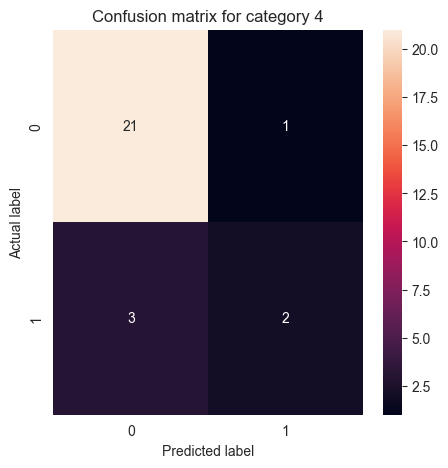

Category 5:

Accuracy: 0.9259259259259259
Precision: 1.0
Recall: 0.3333333333333333
F1 Score: 0.5



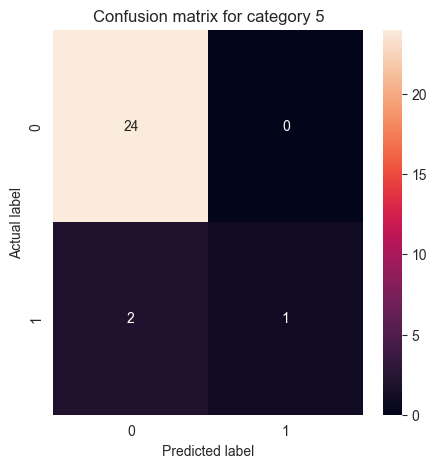

Category 6:

Accuracy: 0.9629629629629629
Precision: 0.0
Recall: 0.0
F1 Score: 0.0



/Users/taliyas/PycharmProjects/NER/venv/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


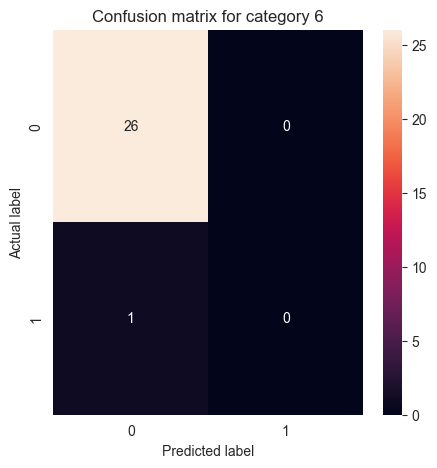

In [153]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns
import numpy as np

for i in range(binary_predictions.shape[1]):
    print(f"Category {i+1}:\n")

    true_labels = y_true[:, i]
    predicted_labels = binary_predictions[:, i]

    # Calculate metrics
    accuracy = accuracy_score(true_labels, predicted_labels)
    precision = precision_score(true_labels, predicted_labels)
    recall = recall_score(true_labels, predicted_labels)
    f1 = f1_score(true_labels, predicted_labels)

    print(f"Accuracy: {accuracy}")
    print(f"Precision: {precision}")
    print(f"Recall: {recall}")
    print(f"F1 Score: {f1}\n")

    # Plot confusion matrix
    cm = confusion_matrix(true_labels, predicted_labels)
    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f'Confusion matrix for category {i+1}')
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    plt.show()
